In [37]:
# Imports
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from google.cloud import bigquery
from google.oauth2 import service_account

In [38]:
!pip install --upgrade google-cloud-bigquery
!pip install --upgrade google-auth


In [39]:
!pip install --upgrade google-auth-oauthlib


In [40]:
from google.cloud import bigquery
from google.oauth2 import service_account


In [41]:
 # Chemin vers ta clé JSON
KEY_PATH = "cle_bigquery.json"

# Authentification
credentials = service_account.Credentials.from_service_account_file(KEY_PATH)

# Création du client BigQuery
client = bigquery.Client(credentials=credentials, project=credentials.project_id)

# Test : afficher les datasets de ton projet
for dataset in client.list_datasets():
    print("Dataset trouvé :", dataset.dataset_id)

Dataset trouvé : dataset_airflow
Dataset trouvé : dataset_image
Dataset trouvé : dataset_raw
Dataset trouvé : dataset_transformed_by_dbt
Dataset trouvé : dbt_khamam
Dataset trouvé : dbt_nbennettayeb
Dataset trouvé : dev_jeanlaurent
Dataset trouvé : dev_sbeghin
Dataset trouvé : tests


In [46]:
# Requête SQL : on sélectionne les colonnes nécessaires
query = """
SELECT 
  id_commande,
  note_client, 
  delai_commande, 
  retard_livraison, 
  montant_commande_apres_promotion,  -- virgule ajoutée ici
  plainte, 
  type_plainte
FROM `carttrend-460508.dbt_khamam.performance_retard_satisfaction`
WHERE note_client IS NOT NULL 
  AND delai_commande IS NOT NULL 
  AND retard_livraison IS NOT NULL

"""


In [47]:
# Exécution et récupération dans un DataFrame
df = client.query(query).to_dataframe()
df.head()

C:\Users\kahin\anaconda3\Lib\site-packages\google\cloud\bigquery\table.py:1957: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


,id_commande,note_client,delai_commande,retard_livraison,montant_commande_apres_promotion,plainte,type_plainte
0,CMD19753,1,2,False,0.00,True,Product
1,CMD14980,5,21,True,9.27,False,
2,CMD35163,2,28,True,27.85,True,Customer Service
3,CMD52624,2,29,True,32.42,True,Delivery
4,CMD13845,5,6,False,26.01,False,


In [50]:
# Vérifie le nom des colonnes exactes
query = """
SELECT *
FROM `carttrend-460508.dbt_khamam.performance_retard_satisfaction`
"""


In [51]:
df = client.query(query).to_dataframe()
df.head()


C:\Users\kahin\anaconda3\Lib\site-packages\google\cloud\bigquery\table.py:1957: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


,id_commande,date_commande,date_livraison_estimee,annee_mois,delai_commande,montant_commande_apres_promotion,mediane,retard_livraison,note_client,plainte,type_plainte
0,CMD41435,2024-07-21,2024-08-12,2024-08,22,11.42,16.0,True,3,False,
1,CMD46003,2024-08-25,2024-09-08,2024-09,14,13.93,16.0,False,4,False,
2,CMD28672,2024-04-20,2024-05-18,2024-05,28,0.00,16.0,True,3,False,
3,CMD28861,2024-04-22,2024-04-26,2024-04,4,18.63,16.0,False,5,False,
4,CMD33271,2024-05-26,2024-06-17,2024-06,22,0.00,16.0,True,1,True,Product


In [52]:
!pip install db-dtypes


In [53]:
 # afficher le nombre total de lignes et de colonnes, le type, le nb de valeurs non nulles
print(df.info())
print(df.describe())
print(df['note_client'].value_counts())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 11 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   id_commande                       5000 non-null   object 
 1   date_commande                     5000 non-null   dbdate 
 2   date_livraison_estimee            5000 non-null   dbdate 
 3   annee_mois                        5000 non-null   object 
 4   delai_commande                    5000 non-null   Int64  
 5   montant_commande_apres_promotion  5000 non-null   float64
 6   mediane                           5000 non-null   float64
 7   retard_livraison                  5000 non-null   boolean
 8   note_client                       5000 non-null   Int64  
 9   plainte                           5000 non-null   boolean
 10  type_plainte                      5000 non-null   object 
dtypes: Int64(2), boolean(2), dbdate(2), float64(2), object(3)
memory usag

In [54]:
# Nettoyer les colonnes: Les colonnes sont bien numériques et ne contiennent pas de valeurs manquantes
df_clean = df[['note_client', 'delai_commande']].dropna()


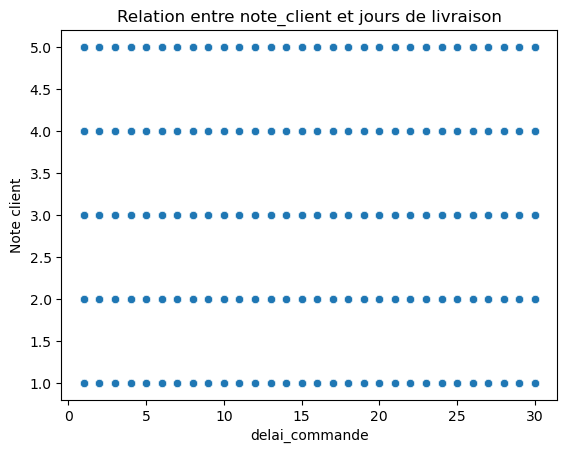

In [55]:
# Visualiser la relation entre note client et jours de livraison ( delai_commande)
import seaborn as sns
import matplotlib.pyplot as plt

sns.scatterplot(x='delai_commande', y='note_client', data=df_clean)
plt.title('Relation entre note_client et jours de livraison')
plt.xlabel('delai_commande')
plt.ylabel('Note client')
plt.show()


# Réaliser la régression linéaire

In [56]:
# Séparer X (variable explicative) et y (variable cible)
X = df_clean[['delai_commande']]  # Doit être un DataFrame
y = df_clean['note_client']


In [57]:
# Importer et entraîner le modèle
from sklearn.linear_model import LinearRegression

model = LinearRegression()
model.fit(X, y)


LinearRegression()

In [58]:
# Analyser les résultats
print(f'Intercept : {model.intercept_}')
print(f'Coefficient : {model.coef_[0]}')


Intercept : 2.987610746046286
Coefficient : 0.0024402519697861113


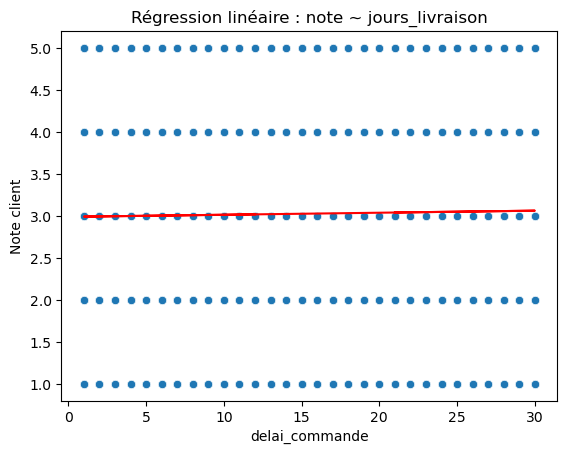

In [17]:
# Tracer la droite de régression:
sns.scatterplot(x='delai_commande', y='note_client', data=df_clean)
plt.plot(X, model.predict(X), color='red')  # droite de régression
plt.title('Régression linéaire : note ~ jours_livraison')
plt.xlabel('delai_commande')
plt.ylabel('Note client')
plt.show()


In [18]:
# Interpretation des coefficients
# Modèle de régression :note_client=2.9876+0.00244×jours_livraison
# Intercept = 2.9876 Si le délai de livraison est 0 jours, la note client estimée serait  2.99. 
# C'est la valeur de départ de la note client quand il n'y a aucun délai..
# Coefficient =  0.00244. Pour chaque jour de livraison supplémentaire, la note client diminue fait augmenter la note client de 0.00244 points.
# Le coefficient est très faible : l’impact de la variable explicative est quasiment nul sur la note.
# le temps de livraison n’influence presque pas la satisfaction, ou qu’il y a d’autres facteurs bien plus important.

In [59]:
# Importer les métriques et faire les prédictions
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np
y_pred = model.predict(X)  # X est jours_livraison (delai_commande)


In [60]:
# Calculer et afficher les scores

mae = mean_absolute_error(y, y_pred)
rmse = np.sqrt(mean_squared_error(y, y_pred))
r2 = r2_score(y, y_pred)

print("MAE :", mae)
print("RMSE :", rmse)
print("R² :", r2)


MAE : 1.207651949047649
RMSE : 1.4174295967221293
R² : 0.00022302369023285973


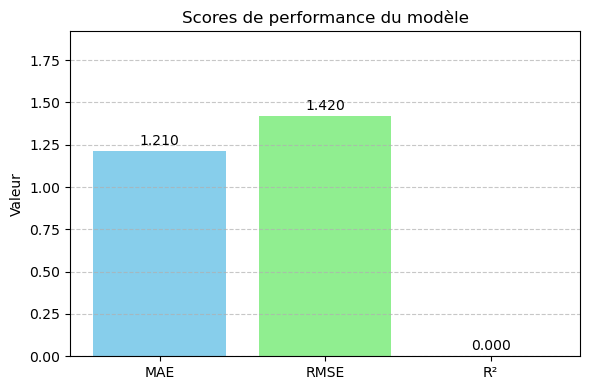

In [61]:
import matplotlib.pyplot as plt

# Métriques
metrics = ['MAE', 'RMSE', 'R²']
values = [1.21, 1.42, 0.0002]  # Tu peux garder les vraies valeurs plus précises si tu veux

# Création du graphique
plt.figure(figsize=(6, 4))
bars = plt.bar(metrics, values, color=['skyblue', 'lightgreen', 'salmon'])

# Affichage des valeurs au-dessus des barres
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.02, f"{yval:.3f}", ha='center', va='bottom')

plt.title("Scores de performance du modèle")
plt.ylabel("Valeur")
plt.ylim(0, max(values) + 0.5)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


# Interpretation des scores
# MAE (Mean Absolute Error) = 1.21 C’est assez élevé pour une variable comme une note client (souvent sur 5). Cela montre que les prédictions manquent un peu de précision.
# RMSE (Root Mean Squared Error) = 1.42 >1 sur une échelle de notes de 0 à 5 reste important.Cela confirme que le modèle a du mal à faire des prédictions précises
# R² (Coefficient de détermination) = 0.0002 le modèle n’explique que 2% de la variance des notes clients à partir du délai de livraison.le modele n’explique quasiment rien.
# Le lien entre jours de livraison et note du client est très faible ou inexistant.D’autres variables (qualité produit, service client, erreurs, type de plainte, etc.) influencent probablement la note.



# Quels facteurs influencent le plus la satisfaction client ?

In [22]:
# Régression linéaire multiple

In [62]:
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
import pandas as pd


In [63]:
# Encodage des variables catégorielles
df_encoded = pd.get_dummies(df, columns=['type_plainte'], drop_first=True)

# Supprimer les lignes avec valeurs manquantes sur les colonnes utiles
df_encoded = df_encoded.dropna(subset=['note_client', 'delai_commande', 'montant_commande_apres_promotion','retard_livraison', 'plainte'])


In [64]:
 print(df.columns)


Index(['id_commande', 'date_commande', 'date_livraison_estimee', 'annee_mois',
       'delai_commande', 'montant_commande_apres_promotion', 'mediane',
       'retard_livraison', 'note_client', 'plainte', 'type_plainte'],
      dtype='object')


In [65]:
X = df_encoded[['delai_commande', 'montant_commande_apres_promotion','retard_livraison', 'plainte'] + 
               [col for col in df_encoded.columns if col.startswith('type_plainte_')]]

# Convertir les booléens en int (True → 1, False → 0)
X = X.astype(int)

y = df_encoded['note_client']


In [66]:
# Ajouter constante pour l'interception
X = sm.add_constant(X)

# Créer et ajuster le modèle
model = sm.OLS(y, X).fit()

# Résumé des résultats
print(model.summary())


                            OLS Regression Results                            
Dep. Variable:            note_client   R-squared:                       0.749
Model:                            OLS   Adj. R-squared:                  0.748
Method:                 Least Squares   F-statistic:                     2126.
Date:                Sun, 01 Jun 2025   Prob (F-statistic):               0.00
Time:                        23:08:43   Log-Likelihood:                -5385.6
No. Observations:                5000   AIC:                         1.079e+04
Df Residuals:                    4992   BIC:                         1.084e+04
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                                       coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
const   

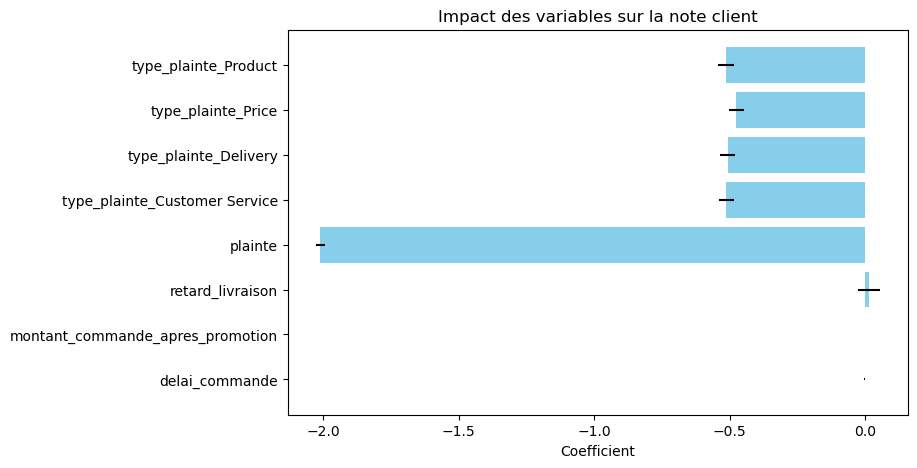

In [67]:
import matplotlib.pyplot as plt

coefs = model.params[1:]  # Sans l'intercept
errors = model.bse[1:]
labels = coefs.index

plt.figure(figsize=(8,5))
plt.barh(labels, coefs, xerr=errors, color='skyblue')
plt.xlabel('Coefficient')
plt.title('Impact des variables sur la note client')
plt.show()


In [68]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# Prédire les valeurs sur le dataset d'entraînement (ou sur un test set si tu en as un)
y_pred = model.predict(X)

# Calculer MAE
mae = mean_absolute_error(y, y_pred)

# Calculer RMSE
rmse = np.sqrt(mean_squared_error(y, y_pred))

# Calculer R²
r2 = r2_score(y, y_pred)

print(f"MAE : {mae:.4f}")
print(f"RMSE : {rmse:.4f}")
print(f"R² : {r2:.4f}")


MAE : 0.6053
RMSE : 0.7105
R² : 0.7488


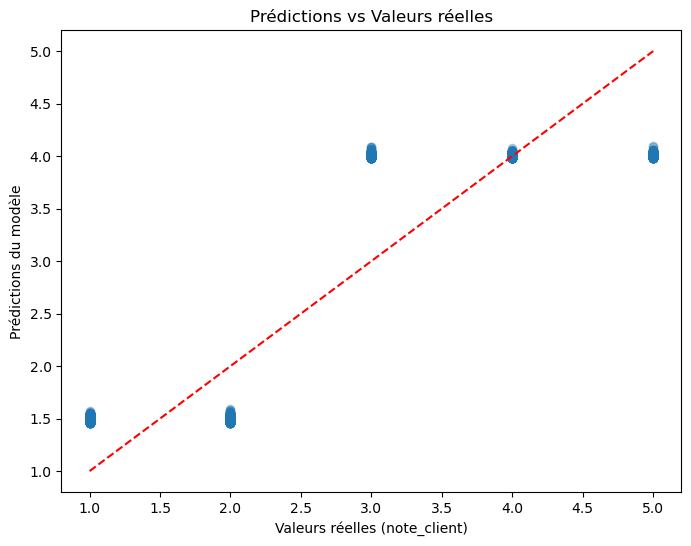

In [69]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,6))
plt.scatter(y, y_pred, alpha=0.3)
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--')  # ligne y=x
plt.xlabel('Valeurs réelles (note_client)')
plt.ylabel('Prédictions du modèle')
plt.title('Prédictions vs Valeurs réelles')
plt.show()


In [ ]:
# R² de 0.75 signifie que ton modèle explique 75% de la variation de la note client à partir des variables comme le délai de commande, la présence d’une plainte, le type de plainte
# Le RMSE est l’erreur quadratique moyenne. Il donne la moyenne des écarts entre les prédictions et les vraies valeurs.
# la note_client semble être sur une échelle de 1 à 5, un RMSE de 0.71 veut dire que le modèle se trompe en moyenne de 0.71 point sur cette échelle.
# C’est acceptable, mais cela montre qu’il reste une marge d’erreur.



# La plainte est un signal fort de mécontentement, à traiter en priorité.

# Les types de plaintes les plus nocifs sont liés au produit.

# Les retards et délais sont moins pénalisants que prévu — ou mal perçus/mesurés.

# recommander à Carttrend de :

# Renforcer la gestion des plaintes (en particulier produit).

# Analyser plus finement les causes des plaintes produit.

# Moins se focaliser uniquement sur les retards si la donnée n’est pas fiable ou significative.


In [71]:
!pip install shap


   ---------------------------------------- 0.0/545.2 kB ? eta -:--:--
   ---------------------------------------- 545.2/545.2 kB 8.8 MB/s eta 0:00:00


#  Modele Random Forest Regressor (Forêt Aléatoire pour la Régression)

R2 test: 0.712
RMSE test: 0.770
plainte: 0.752
montant_commande_apres_promotion: 0.156
delai_commande: 0.082
retard_livraison: 0.003
type_plainte_Customer Service: 0.002
type_plainte_Price: 0.002
type_plainte_Delivery: 0.002
type_plainte_Product: 0.002


C:\Users\kahin\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
 94%|=================== | 939/1000 [00:16<00:01]       

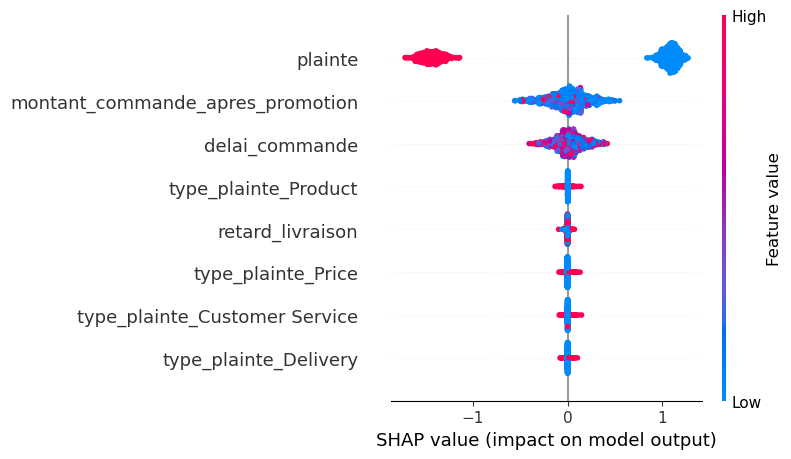

In [72]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
import shap

# Séparer features et cible
X = df_encoded[['delai_commande', 'montant_commande_apres_promotion','retard_livraison', 'plainte'] + 
               [col for col in df_encoded.columns if col.startswith('type_plainte_')]]
y = df_encoded['note_client']

# Conversion bool en int si nécessaire
X = X.astype(int)

# Split train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Modèle Random Forest
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# Prédiction et score
y_pred = rf.predict(X_test)
print(f"R2 test: {r2_score(y_test, y_pred):.3f}")
print(f"RMSE test: {mean_squared_error(y_test, y_pred, squared=False):.3f}")

# Importance des variables
importances = rf.feature_importances_
features = X.columns
for feat, imp in sorted(zip(features, importances), key=lambda x: x[1], reverse=True):
    print(f"{feat}: {imp:.3f}")

# Explication fine avec SHAP
explainer = shap.Explainer(rf, X_train)
shap_values = explainer(X_test)
shap.summary_plot(shap_values, X_test)


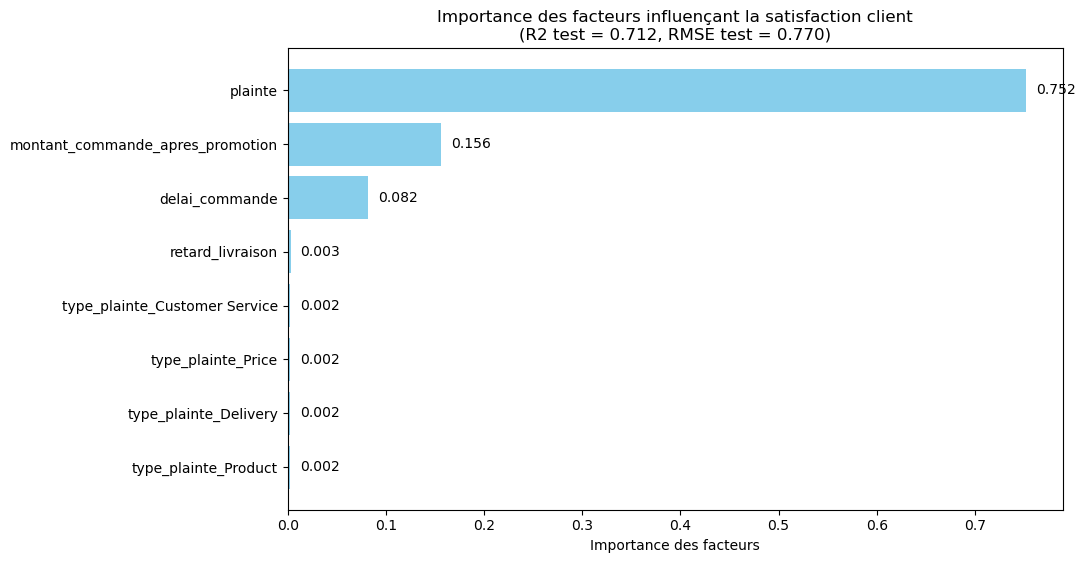

In [73]:
import matplotlib.pyplot as plt

# Variables et leurs importances
features = [
    "plainte",
    "montant_commande_apres_promotion",
    "delai_commande",
    "retard_livraison",
    "type_plainte_Customer Service",
    "type_plainte_Price",
    "type_plainte_Delivery",
    "type_plainte_Product"
]

importances = [0.752, 0.156, 0.082, 0.003, 0.002, 0.002, 0.002, 0.002]

# Création du graphique
plt.figure(figsize=(10,6))
bars = plt.barh(features, importances, color='skyblue')
plt.xlabel('Importance des facteurs')
plt.title('Importance des facteurs influençant la satisfaction client\n(R2 test = 0.712, RMSE test = 0.770)')

# Inverser l'ordre pour que le plus important soit en haut
plt.gca().invert_yaxis()

# Ajouter les valeurs au bout des barres
for bar in bars:
    width = bar.get_width()
    plt.text(width + 0.01, bar.get_y() + bar.get_height()/2, f'{width:.3f}', va='center')

plt.show()
